In [1]:
import torch
import torchvision as tv
import torch.nn as nn


C:\Users\alexb\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] Das angegebene Modul wurde nicht gefunden
  warn(f"Failed to load image Python extension: {e}")


In [2]:
batch_size=32

transform  = tv.transforms.Compose([tv.transforms.ToTensor()])
train_set = tv.datasets.MNIST(root='./MNIST/train', download=True,train=True, transform=transform)
train_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = tv.datasets.MNIST(root='./MNIST/test', download=True,train=False, transform=transform)
test_data = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(len(train_data))

1875


torch.Size([117, 233, 3])


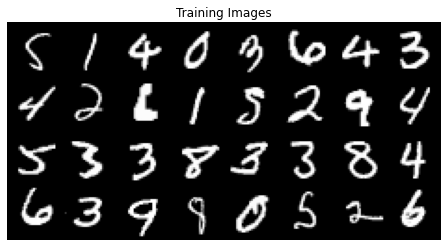

In [3]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

image,_ = next(iter(train_data)) #real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Training Images")
train_ims=vutils.make_grid(image[:64],padding=1,normalize=True)
print(np.transpose(train_ims.cpu(),(1,2,0)).shape)
plt.imshow(np.transpose(train_ims.cpu(),(1,2,0)))
vutils.save_image(train_ims,"Training_images.png")

In [4]:
class VAE_conv(nn.Module):
    def __init__(self,device, z_dim=32):
        super(VAE_conv, self).__init__()
        self.h_dim=128
        self.z_dim=z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, self.h_dim, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(self.h_dim, z_dim)
        self.fc2 = nn.Linear(self.h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.h_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.h_dim, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=1),
            nn.Upsample([28,28]),
            nn.Sigmoid(),
        )
        self.encoder.to(device)
        self.decoder.to(device)
        self.fc1.to(device)
        self.fc2.to(device)
        self.fc3.to(device)
    
    def encode(self, x):
        h = self.encoder(x)
        mu, logsig = self.fc1(h), self.fc2(h)

        return mu,logsig

    def decode(self, z):
        z = self.fc3(z).view(-1,self.h_dim,1,1)
        z = self.decoder(z)

        return z


In [5]:
class VAE(nn.Module):
    def __init__(self, device,z_dim):
        super(VAE, self).__init__()
        
        self.z_dim=z_dim
        self.encoder=nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,2*z_dim)
        )

        self.decoder=nn.Sequential(
            nn.Linear(LATENT_DIM,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,28*28),
            nn.Sigmoid()
        )  
        self.encoder.to(device)
        self.decoder.to(device) 
    
    def encode(self, x):
        h = self.encoder(x)
        mu,logsig=torch.split(h,self.z_dim,1)

        return mu,logsig

    def decode(self, z):
        z = self.decoder(z)

        return z


In [8]:
import os
LATENT_DIM=20
device=torch.device('cuda')

conv=True
if conv:
  vae=VAE_conv(device,z_dim=LATENT_DIM)
else:
  vae=VAE(device,z_dim=LATENT_DIM)

print(sum(p.numel() for p in vae.parameters() if p.requires_grad))


path="./Conv_"+str(conv)+"_LATENT_DIM_"+str(LATENT_DIM)
if not os.path.exists(path):
  pass
  #os.makedirs(path)



575845


In [ ]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn.functional as F

def train(max_epochs,train_dataload,test_dataload,vae,writer):
    
    optim_model=optim.Adam(vae.parameters(),lr=0.0001)
    iter=0
    train_loss=0
    for epoch in range(max_epochs):
        for i,(x,_) in enumerate(train_dataload):
            optim_model.zero_grad()
            x=x.to(device)
           
            mu,logsig=vae.encode(x)
            
            writer.add_scalar("Mu/1st coord", mu[:,0].mean(), iter)
            writer.add_scalar("Mu/2nd coord", mu[:,1].mean(), iter)
                  
            latent_loss=-0.5*torch.sum(1+logsig-mu.pow(2)-torch.exp(logsig))
            
            dist=Normal(0,1)
            z=mu+torch.exp(logsig).pow(0.5)*dist.rsample(mu.shape).to(device)

            out=vae.decode(z).view(-1,28*28)
            reconstruction_loss=F.binary_cross_entropy(out, x.view(-1,28*28),reduction="sum")

            loss=latent_loss+reconstruction_loss
            loss.backward()
            optim_model.step()

            writer.add_scalar("Losses/Train loss", loss.item(), iter)

            iter+=1
        
            train_loss+=loss.item()
           
            if epoch%5==0 and i==0:

                fig = plt.figure(figsize=(8, 4))

                ax1=fig.add_subplot(121)
                ax1.set_title("Training Images Epoch "+str(epoch))
                ax1.axis('off')
                originals=vutils.make_grid(x.view(-1,1,28,28), padding=2, normalize=True)
                plt.imshow(np.transpose(originals.cpu(),(1,2,0)))

                ax2=fig.add_subplot(122)
                ax2.set_title("Reconstructions Epoch "+str(epoch))
                ax2.axis('off')
                reconstructed=vutils.make_grid(out.view(-1,1,28,28), padding=2, normalize=True)
                plt.imshow(np.transpose(reconstructed.cpu(),(1,2,0)))

                fig.savefig(path+"/Train_epoch"+str(epoch))


        train_loss=train_loss/len(train_dataload)
        test_loss=0
        for i,(x,_) in enumerate(test_dataload):
            with torch.no_grad():
                x=x.to(device)
           
                mu,logsig=vae.encode(x)
                latent_loss=-0.5*torch.sum(1+logsig-mu.pow(2)-torch.exp(logsig))

                dist=Normal(0,1)
                z=mu+torch.exp(logsig).pow(0.5)*dist.rsample(mu.shape).to(device)
                
                out=vae.decode(z).view(-1,28*28)
                reconstruction_loss=F.binary_cross_entropy(out, x.view(-1,28*28),reduction='sum')

                loss=latent_loss+reconstruction_loss
                test_loss+=loss.item()
                
                if epoch%5==0 and i==0:

                    fig = plt.figure(figsize=(8, 4))

                    ax1=fig.add_subplot(121)
                    ax1.set_title("Test Images Epoch "+str(epoch))
                    ax1.axis('off')
                    originals=vutils.make_grid(x.view(-1,1,28,28), padding=2, normalize=True)
                    plt.imshow(np.transpose(originals.cpu(),(1,2,0)))

                    ax2=fig.add_subplot(122)
                    ax2.set_title("Reconstructions Epoch "+str(epoch))
                    ax2.axis('off')
                    reconstructed=vutils.make_grid(out.view(-1,1,28,28), padding=2, normalize=True)
                    plt.imshow(np.transpose(reconstructed.cpu(),(1,2,0)))

                    fig.savefig(path+"/Test_epoch"+str(epoch))

                    fig = plt.figure(figsize=(4, 4))
                    ax1=fig.add_subplot(111)
                    ax1.set_title("Generated Images Epoch "+str(epoch))
                    ax1.axis('off')
                    with torch.no_grad():
                        z = torch.randn(batch_size, LATENT_DIM).cuda()
                        out=vae.decode(z).view(-1,1,28,28)
                    img=vutils.make_grid(out, padding=2, normalize=True)
                    plt.imshow(np.transpose(img.cpu(),(1,2,0)))
                    fig.savefig(path+"/Generated_epoch"+str(epoch))

        test_loss=test_loss/len(test_dataload)
        writer.add_scalar("Losses/Test loss", test_loss, epoch)


        print('EPOCH: [%d/%d]\tTRAIN LOSS: %.4f\t TEST LOSS: %.4f' % (epoch, max_epochs, train_loss, test_loss))

EPOCH: [0/31]	TRAIN LOSS: 6208.0361	 TEST LOSS: 5.0923


EPOCH: [1/31]	TRAIN LOSS: 5346.3239	 TEST LOSS: 5.3122


EPOCH: [2/31]	TRAIN LOSS: 5145.1361	 TEST LOSS: 5.6587


EPOCH: [3/31]	TRAIN LOSS: 5012.7757	 TEST LOSS: 6.0584


EPOCH: [4/31]	TRAIN LOSS: 4934.5497	 TEST LOSS: 6.0905


EPOCH: [5/31]	TRAIN LOSS: 4875.9626	 TEST LOSS: 6.2044


EPOCH: [6/31]	TRAIN LOSS: 4833.1176	 TEST LOSS: 6.4731


EPOCH: [7/31]	TRAIN LOSS: 4795.6530	 TEST LOSS: 6.3861


EPOCH: [8/31]	TRAIN LOSS: 4767.4622	 TEST LOSS: 6.5546


EPOCH: [9/31]	TRAIN LOSS: 4742.5730	 TEST LOSS: 6.3184


EPOCH: [10/31]	TRAIN LOSS: 4719.8119	 TEST LOSS: 6.6003


EPOCH: [11/31]	TRAIN LOSS: 4699.8196	 TEST LOSS: 6.5731


EPOCH: [12/31]	TRAIN LOSS: 4683.7494	 TEST LOSS: 6.5682


EPOCH: [13/31]	TRAIN LOSS: 4670.4204	 TEST LOSS: 6.6869


EPOCH: [14/31]	TRAIN LOSS: 4654.7173	 TEST LOSS: 6.4949


EPOCH: [15/31]	TRAIN LOSS: 4641.5490	 TEST LOSS: 6.9476


EPOCH: [16/31]	TRAIN LOSS: 4629.1857	 TEST LOSS: 6.4911


EPOCH: [17/31]	TRAIN LOSS: 4617.3968	 TEST LOSS: 6.5980


EPOCH: [18/31]	TRAIN LOSS: 4608.2779	 TEST LOSS: 6.6661


EPOCH: [19/31]	TRAIN LOSS: 4596.9000	 TEST LOSS: 6.7816


EPOCH: [20/31]	TRAIN LOSS: 4588.0978	 TEST LOSS: 6.7915


EPOCH: [21/31]	TRAIN LOSS: 4580.5917	 TEST LOSS: 6.7300


EPOCH: [22/31]	TRAIN LOSS: 4571.4522	 TEST LOSS: 6.7267


EPOCH: [23/31]	TRAIN LOSS: 4564.1546	 TEST LOSS: 6.9206


EPOCH: [24/31]	TRAIN LOSS: 4556.1332	 TEST LOSS: 6.7897


EPOCH: [25/31]	TRAIN LOSS: 4548.0950	 TEST LOSS: 6.6886


EPOCH: [26/31]	TRAIN LOSS: 4541.9526	 TEST LOSS: 6.9747


EPOCH: [27/31]	TRAIN LOSS: 4536.7828	 TEST LOSS: 6.8198


EPOCH: [28/31]	TRAIN LOSS: 4529.2431	 TEST LOSS: 6.9341


EPOCH: [29/31]	TRAIN LOSS: 4526.0239	 TEST LOSS: 6.8687


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


EPOCH: [30/31]	TRAIN LOSS: 4519.0596	 TEST LOSS: 6.8102


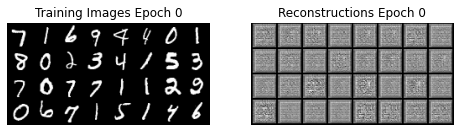

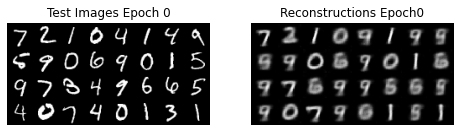

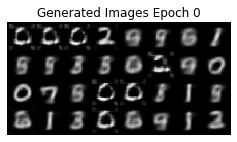

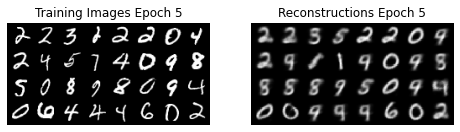

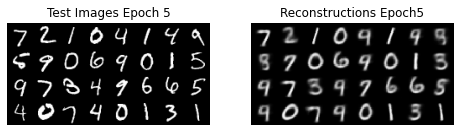

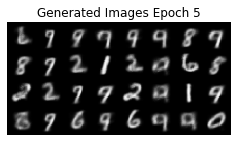

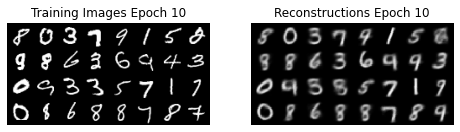

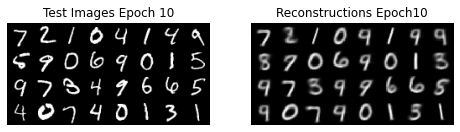

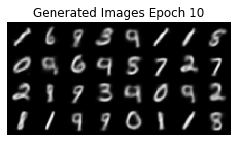

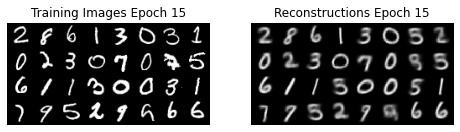

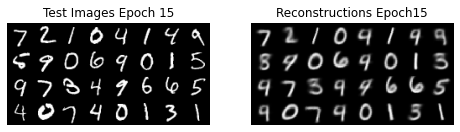

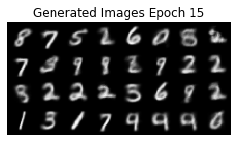

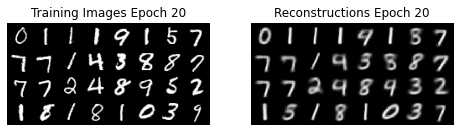

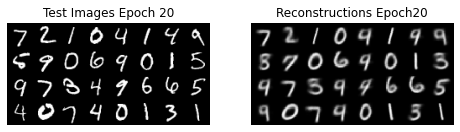

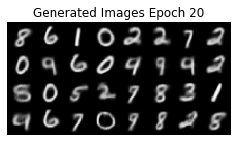

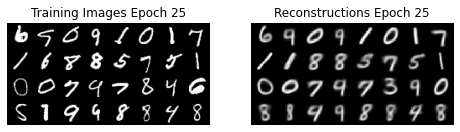

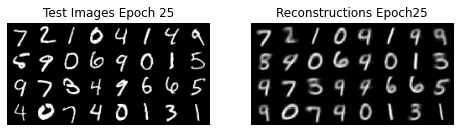

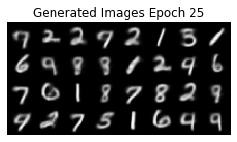

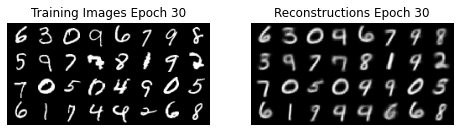

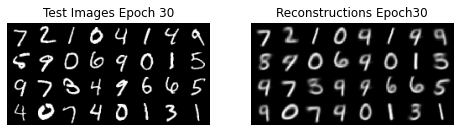

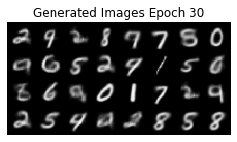

In [8]:
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter(path)
max_epochs=31
train(max_epochs,train_data,test_data, vae,writer)
torch.save(vae.state_dict(),path+"/model.txt")

In [ ]:
import os
conv=True
LATENT_DIM=20
#!zip -r file.zip "./Conv_False_LATENT_DIM_20"
!zip -r file.zip "/kaggle/working"

In [12]:
vae.load_state_dict(torch.load(path+"/model.txt"))

<All keys matched successfully>

In [14]:
fig=plt.figure()
with torch.no_grad():
    for x,y in test_data:
        x=x.to(device)
        mu,logsig=vae.encode(x)
        mu=mu.cpu().numpy()
        ax=plt.scatter(mu[:,0],mu[:,1],c=y,s=10)
    plt.colorbar(ax)

plt.show   

<function matplotlib.pyplot.show(*, block=None)>